This notebook for fine-tuning the PaliGemma model wit the RISCM dataset and testing some model performance improvement suggestions.

Install the required packages with the following commands. If you are running this notebook on Colab, the second installation isn't neccessary. Otherwise, choose proper cuda version before installation.

In [1]:
!pip install tensorflow overrides ml_collections sentencepiece einops~=0.7 jax ipython pillow scikit-image matplotlib flax kagglehub polars keras-nightly wandb
# !pip install -U "jax[cuda12]"

We load the data from drive. For other options, this code block isn't neccessary.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Download the Google's "big_vision_repo" to use PaliGemma utilities.

In [3]:
import os
import sys

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
    !git clone --quiet --branch=main --depth=1 https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
    sys.path.append("big_vision_repo")

Import the required packages and check the availability of jax.

In [4]:
import base64
import functools
import html
import io
import warnings
import json

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections
import polars as pl

import tensorflow as tf
from tensorflow.keras import mixed_precision
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

import kagglehub

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt

# Import model definition from big_vision
from big_vision_repo.big_vision.models.proj.paligemma import paligemma
from big_vision_repo.big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
from big_vision_repo.big_vision.datasets.jsonl import DataSource
from big_vision_repo.big_vision.utils import tree_map_with_names, reshard, create_learning_rate_schedule, \
    tree_flatten_with_names
from big_vision_repo.big_vision.sharding import infer_sharding

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

mixed_precision.set_global_policy("mixed_float16")

backend = jax.extend.backend.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.5.2
JAX platform: gpu
JAX devices:  1


If you are using Colab, add your Kaggle credentials to secrets. Otherwise, please define your credentials with the code below.

In [5]:
# os.environ["KAGGLE_USERNAME"] = "KAGGLE_USERNAME"
# os.environ["KAGGLE_KEY"] = "KAGGLE_KEY"

Download the pre-trained model to be fine-tuned. We will use PaliGemma-2 3B model.

In [6]:
# Use these for PaliGemma-2 3B 224px²
LLM_VARIANT = "gemma2_2b"
MODEL_PATH = "./paligemma2-3b-pt-224.b16.npz"
KAGGLE_HANDLE = "google/paligemma-2/jax/paligemma2-3b-pt-224"

"""
# Use these for PaliGemma 1:
LLM_VARIANT = "gemma_2b"
MODEL_PATH = "./paligemma-3b-pt-224.f16.npz"
KAGGLE_HANDLE = "google/paligemma/jax/paligemma-3b-pt-224"
"""

if not os.path.exists(MODEL_PATH):
    print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
    MODEL_PATH = kagglehub.model_download(KAGGLE_HANDLE, MODEL_PATH)
    print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "model/paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
    print("Downloading the model tokenizer...")
    !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
    print(f"Tokenizer path: {TOKENIZER_PATH}")

Model path: /kaggle/input/paligemma-2/jax/paligemma2-3b-pt-224/1/./paligemma2-3b-pt-224.b16.npz


Define the model with the pre-trained weights and default config.

In [7]:
# Define model

# IMPORTANT: Gemma-2 has a "final_logits_softcap" property. Set it to 0.0
# for better transfer results.
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152, "variant": LLM_VARIANT, "final_logits_softcap": 0.0},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

Load all model parameters and add sharding to train the model on multiple GPUs, if available.

In [8]:
# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
    if name.startswith("llm/layers/attn/"):  return True
    if name.startswith("llm/"):              return False
    if name.startswith("img/"):              return False
    raise ValueError(f"Unexpected param name {name}")


trainable_mask = tree_map_with_names(is_trainable_param, params)

# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")


@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
    # Cast others to float16, since some GPUs don't support bf16.
    return jax.tree.map(lambda p, m: p.astype(jnp.float32)
    if m else p.astype(jnp.float16),
                        params, trainable)


# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default.
# Instead, do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
    params[idx] = reshard(params[idx], sharding)
    params[idx] = maybe_cast_to_f32(params[idx], trainable)
    params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)


# Print params to show what the model is made of.
def parameter_overview(params):
    for path, arr in tree_flatten_with_names(params)[0]:
        print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")


print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

Load and transform the data for using the PaliGemma's DataSource object. While doing this, drop duplicate or partially unavailable samples.

In [9]:
from google.colab import userdata

data_path = userdata.get('DATA_PATH')  # Add data path as a Colab secret or give the direct path of the data
images_folder = "resized/"
captions_path = data_path + "captions.csv"

df_input = pl.read_csv(captions_path, separator=",", glob=False)
splits = df_input.select('split').unique()['split'].to_list()
for split in splits:
    filename = f"{data_path}{split}_captions.jsonl"
    if not os.path.isfile(filename):
        print(f"{split}_captions not found, starting to process...")
        df_split = df_input.filter(pl.col('split') == split)
        with open(filename, 'w') as f:
            for row in df_split.iter_rows(named=True):
                if os.path.isfile(f"{data_path}{images_folder}{row['image']}"):  # Skip the annotation if referenced image does not exist
                    for i in range(1, 6):
                        json_object = {
                            "prefix": "",
                            "image": f"{images_folder}{row['image']}",
                            "suffix": row[f"caption_{i}"],  # TODO: remove duplicate samples
                        }
                        f.write(json.dumps(json_object) + '\n')
    else:
        print(f"{split}_captions is already processed, skipping...")

val_captions is already processed, skipping...
train_captions is already processed, skipping...
test_captions is already processed, skipping...


Define preprocess and postprocess methods.

In [10]:
def preprocess_image(image, size=224):
    # Model has been trained to handle images of different aspects ratios
    # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
    # options are helpful to improve quality in some tasks.

    image = np.asarray(image)
    if image.ndim == 2:  # Convert image without last channel into greyscale.
        image = np.stack((image,) * 3, axis=-1)
    image = image[..., :3]  # Remove alpha layer.
    assert image.shape[-1] == 3

    image = tf.constant(image)
    image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
    return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]


def preprocess_tokens(prefix, suffix=None, seqlen=None):
    # Model has been trained to handle tokenized text composed of a prefix with
    # full attention and a suffix with causal attention.
    separator = "\n"
    tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
    mask_ar = [0] * len(tokens)  # 0 to use full attention for prefix.
    mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

    if suffix:
        suffix = tokenizer.encode(suffix, add_eos=True)
        tokens += suffix
        mask_ar += [1] * len(suffix)  # 1 to use causal attention for suffix.
        mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

    mask_input = [1] * len(tokens)  # 1 if it's a token, 0 if padding.
    if seqlen:
        padding = [0] * max(0, seqlen - len(tokens))
        tokens = tokens[:seqlen] + padding
        mask_ar = mask_ar[:seqlen] + padding
        mask_loss = mask_loss[:seqlen] + padding
        mask_input = mask_input[:seqlen] + padding

    return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))


def postprocess_tokens(tokens):
    tokens = tokens.tolist()  # np.array to list[int]
    try:  # Remove tokens at and after EOS if any.
        eos_pos = tokens.index(tokenizer.eos_id())
        tokens = tokens[:eos_pos]
    except ValueError:
        pass
    return tokenizer.decode(tokens)

Define the datasets and the data loaders.

In [11]:
SEQLEN = 128

train_dataset = DataSource(
    os.path.join(data_path, "train_captions.jsonl"),
    fopen_keys={"image": data_path}
)

val_dataset = DataSource(
    os.path.join(data_path, "val_captions.jsonl"),
    fopen_keys={"image": data_path})


def train_data_iterator():
    """Never ending iterator over training examples."""
    # Shuffle examples and repeat so one can train for many epochs.
    dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
    for example in dataset.as_numpy_iterator():
        image = Image.open(io.BytesIO(example["image"]))
        image = preprocess_image(image)

        # TODO: #
        # numSegments = 4 * 4  # 14 * 14
        # segments = slic(image, n_segments=numSegments, sigma=5)
        # image = mark_boundaries(image, segments)
        #########

        prefix = "caption en"  # Could also be a different prefix per example.
        suffix = example["suffix"].decode().lower()
        tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)

        yield {
            "image": np.asarray(image),
            "text": np.asarray(tokens),
            "mask_ar": np.asarray(mask_ar),
            "mask_loss": np.asarray(mask_loss),
        }


def validation_data_iterator():
    """Single iterator over validation examples."""
    for example in val_dataset.get_tfdata().as_numpy_iterator():  # for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
        image = Image.open(io.BytesIO(example["image"]))
        image = preprocess_image(image)

        # TODO: #
        # numSegments = 4 * 4  # 14 * 14
        # segments = slic(image, n_segments=numSegments, sigma=5)
        # image = mark_boundaries(image, segments)
        #########

        prefix = "caption en"  # Could also be a different prefix per example.
        tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

        yield {
            "image": np.asarray(image),
            "text": np.asarray(tokens),
            "mask_ar": np.asarray(mask_ar),
            "mask_input": np.asarray(mask_input),
        }


Display some examples from the training dataset.

Training examples



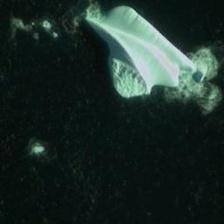
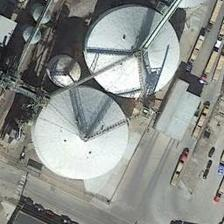
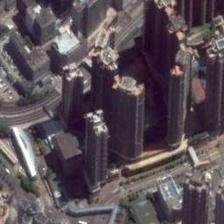
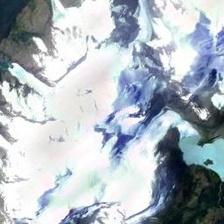
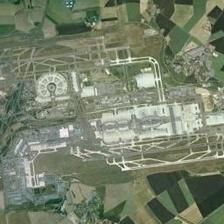
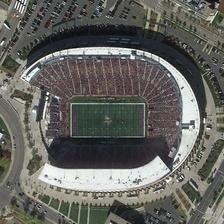
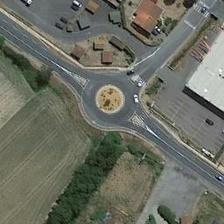
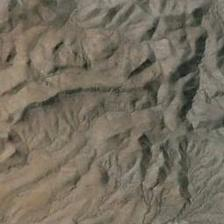

In [12]:
def render_inline(image, resize=(128, 128)):
    """Convert image into inline html."""
    image = Image.fromarray(image)
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"


def render_example(image, caption):
    image = ((image + 1) / 2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
    return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64, 64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
    </div>
    """


html_out = ""
for idx, example in zip(range(8), train_data_iterator()):
    caption = postprocess_tokens(example["text"])  # detokenize model input.
    caption = caption[len("caption en\n"):]  # strip prefix
    html_out += render_example(example["image"], caption)

print("Training examples")
display(HTML(html_out))

Define loss and inference functions.

In [13]:
# The main update_fn using a simple stochastic gradient descent (SGD).
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
    imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

    def loss_fn(params):
        text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
        logp = jax.nn.log_softmax(text_logits, axis=-1)

        # The model takes as input txts[:, :-1] but the loss is defined as predicting
        # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
        # are part of the loss (e.g. prefix and padded tokens are not included).
        mask_loss = batch["mask_loss"][:, 1:]
        targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

        # Compute the loss per example. i.e. the mean of per token pplx.
        # Since each example has a different number of tokens, normalize it.
        token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
        example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
        example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

        # batch_loss: mean of per example loss.
        return jnp.mean(example_loss)

    loss, grads = jax.value_and_grad(loss_fn)(params)

    # Apply gradients to trainable params using SGD.
    def apply_grad(param, gradient, trainable):
        if not trainable: return param
        return param - learning_rate * gradient

    params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

    return params, loss


# Evaluation/inference loop.
def make_predictions(data_iterator, *, params, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
    outputs = []
    while True:
        # Construct a list of examples in the batch.
        examples = []
        try:
            for _ in range(batch_size):
                examples.append(next(data_iterator))
                examples[-1]["_mask"] = np.array(True)  # Indicates true example.
        except StopIteration:
            if len(examples) == 0:
                return outputs

        # Not enough examples to complete a batch. Pad by repeating last example.
        while len(examples) % batch_size:
            examples.append(dict(examples[-1]))
            examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

        # Convert list of examples into a dict of np.arrays and load onto devices.
        batch = jax.tree.map(lambda *x: np.stack(x), *examples)
        batch = reshard(batch, data_sharding)

        # Make model predictions
        tokens = decode({"params": params}, batch=batch,
                        max_decode_len=seqlen, sampler=sampler)

        # Fetch model predictions to device and detokenize.
        tokens, mask = jax.device_get((tokens, batch["_mask"]))
        tokens = tokens[mask]  # remove padding examples.
        responses = [postprocess_tokens(t) for t in tokens]

        # Append to html output.
        for example, response in zip(examples, responses):
            outputs.append((example["image"], response))
            if num_examples and len(outputs) >= num_examples:
                return outputs

Initialize the W&B project and define the hyperparameters to be tested.

In [14]:
import wandb

wandb.login(key=userdata.get('WANDB_KEY'))

project_name = "DI725_project_2389088"

sweep_config = {
    "method": "grid",
    "metric": {
        "name": "train_loss",
        "goal": "minimize"
    },
    "parameters": {
        "batch_size": {
            "values": [2, 4, 6]
        },
        "epochs": {
            "values": [1024, 2048, 3072]
        },
        "learning_rate": {
            "values": [0.05, 0.01, 0.001]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project=project_name)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: erennarin-92 (erennarin-92-metu-middle-east-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: e7hasvhh
Sweep URL: https://wandb.ai/erennarin-92-metu-middle-east-technical-university/DI725_project_2389088/sweeps/e7hasvhh


Start the training with W&B sweeps.

wandb: Agent Starting Run: sasos0dm with config:
wandb: 	batch_size: 2
wandb: 	epochs: 1024
wandb: 	learning_rate: 0.05


img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (27, 1152)             


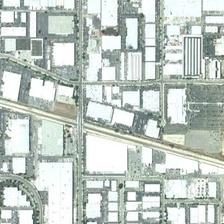
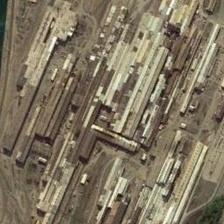
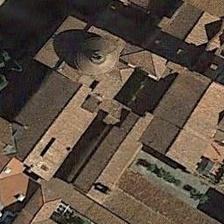
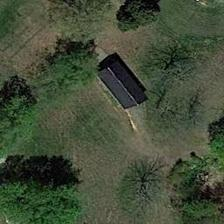
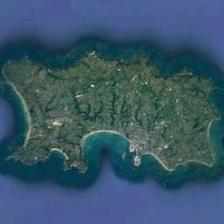
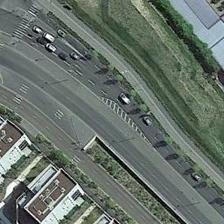
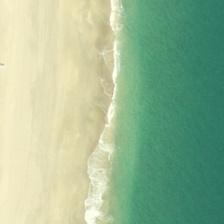
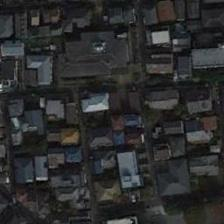
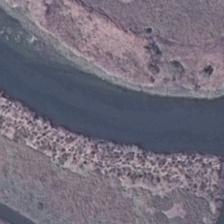
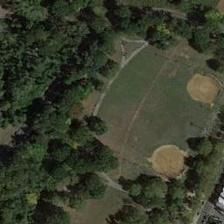

this is step 129
examples made
step: 129/512   lr: 0.04657   loss: 1.5016
this is step 130
examples made
step: 130/512   lr: 0.04648   loss: 2.4226
this is step 131
examples made
step: 131/512   lr: 0.04639   loss: 2.1931
this is step 132
examples made
step: 132/512   lr: 0.04630   loss: 2.4480
this is step 133
examples made
step: 133/512   lr: 0.04621   loss: 0.8586
this is step 134
examples made
step: 134/512   lr: 0.04612   loss: 0.8509
this is step 135
examples made
step: 135/512   lr: 0.04603   loss: 2.5615
this is step 136
examples made
step: 136/512   lr: 0.04594   loss: 2.3697
this is step 137
examples made
step: 137/512   lr: 0.04585   loss: 2.2477
this is step 138
examples made
step: 138/512   lr: 0.04575   loss: 2.0643
this is step 139
examples made
step: 139/512   lr: 0.04566   loss: 2.9396
this is step 140
examples made
step: 140/512   lr: 0.04556   loss: 2.0773
this is step 141
examples made
step: 141/512   lr: 0.04546   loss: 2.3897
this is step 142
examples made
step: 1


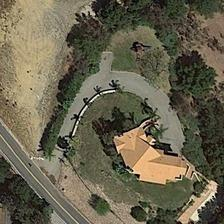
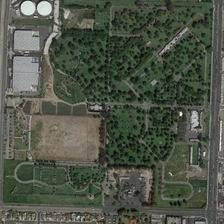
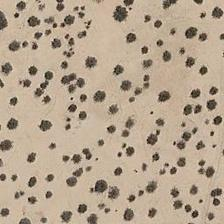
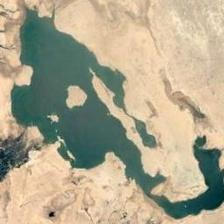
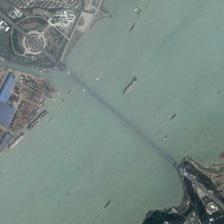
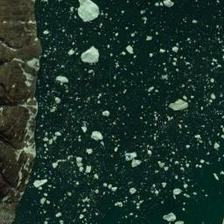
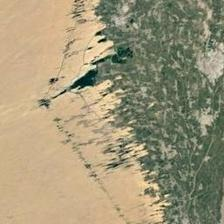
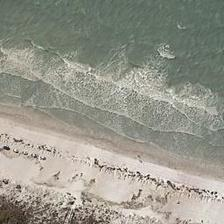
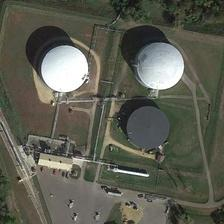
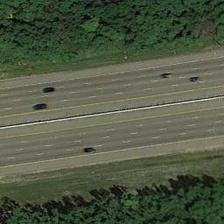

this is step 257
examples made
step: 257/512   lr: 0.02923   loss: 1.5704
this is step 258
examples made
step: 258/512   lr: 0.02906   loss: 2.0069
this is step 259
examples made
step: 259/512   lr: 0.02889   loss: 1.8787
this is step 260
examples made
step: 260/512   lr: 0.02873   loss: 1.9539
this is step 261
examples made
step: 261/512   lr: 0.02856   loss: 3.0661
this is step 262
examples made
step: 262/512   lr: 0.02839   loss: 2.1567
this is step 263
examples made
step: 263/512   lr: 0.02822   loss: 1.7366
this is step 264
examples made
step: 264/512   lr: 0.02805   loss: 0.7795
this is step 265
examples made
step: 265/512   lr: 0.02788   loss: 1.4911
this is step 266
examples made
step: 266/512   lr: 0.02771   loss: 2.6629
this is step 267
examples made
step: 267/512   lr: 0.02755   loss: 1.4442
this is step 268
examples made
step: 268/512   lr: 0.02738   loss: 2.9863
this is step 269
examples made
step: 269/512   lr: 0.02721   loss: 2.1163
this is step 270
examples made
step: 2


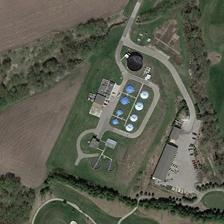
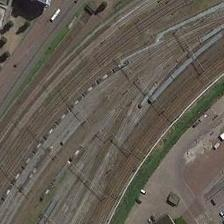
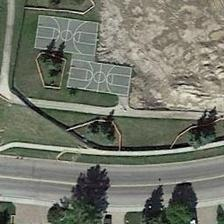
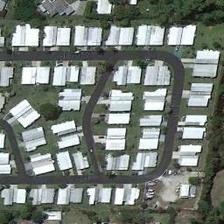
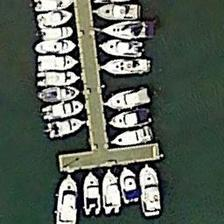
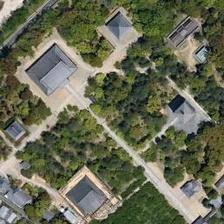
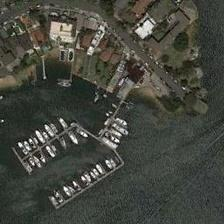
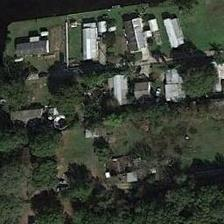
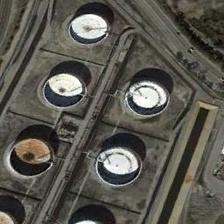
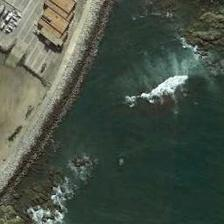

this is step 385
examples made
step: 385/512   lr: 0.00889   loss: 1.6595
this is step 386
examples made
step: 386/512   lr: 0.00876   loss: 1.6912
this is step 387
examples made
step: 387/512   lr: 0.00863   loss: 1.7971
this is step 388
examples made
step: 388/512   lr: 0.00850   loss: 1.3374
this is step 389
examples made
step: 389/512   lr: 0.00837   loss: 2.7108
this is step 390
examples made
step: 390/512   lr: 0.00825   loss: 1.9653
this is step 391
examples made
step: 391/512   lr: 0.00812   loss: 1.6607
this is step 392
examples made
step: 392/512   lr: 0.00800   loss: 1.3658
this is step 393
examples made
step: 393/512   lr: 0.00787   loss: 1.1945
this is step 394
examples made
step: 394/512   lr: 0.00775   loss: 0.9620
this is step 395
examples made
step: 395/512   lr: 0.00763   loss: 1.4706
this is step 396
examples made
step: 396/512   lr: 0.00750   loss: 2.0925
this is step 397
examples made
step: 397/512   lr: 0.00738   loss: 1.7193
this is step 398
examples made
step: 3


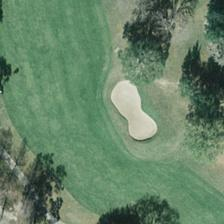
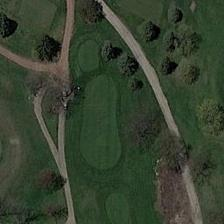
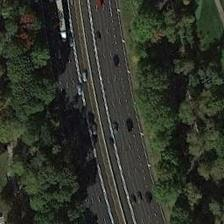
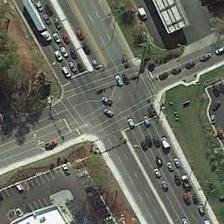
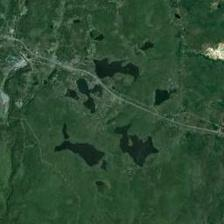
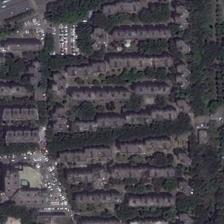
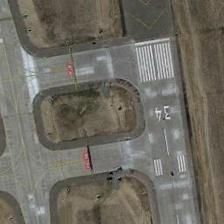
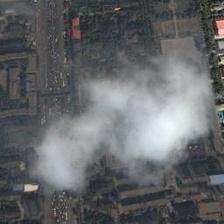
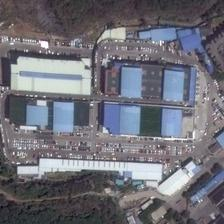
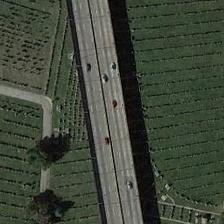

Final model predictions



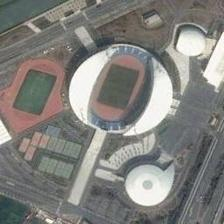
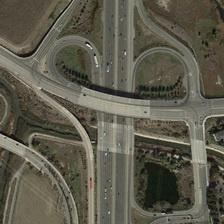
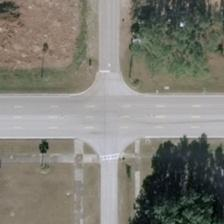
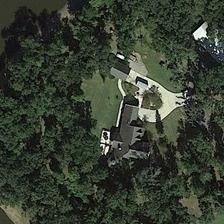
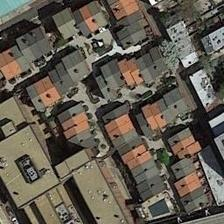
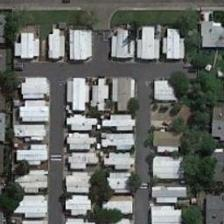
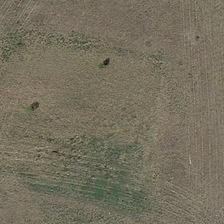
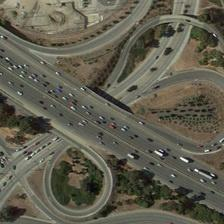
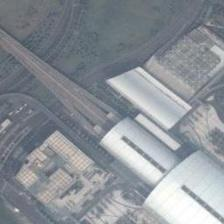
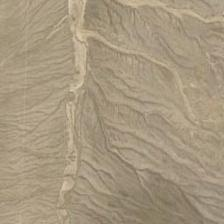

learning_rate,▁▃▃▃▃▆▆▇█████▇▇▇▇▇▇▆▆▅▅▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss,▅▇▅▄▆▅▃▆▆▆▄▆▂▆▆▄▅▄▇▁▇▇▃▄▅▂▄▃▄█▄▅▃▄▃▁▄▄▃▄
learning_rate,0.0
step,512
train_loss,2.89616


wandb: Agent Starting Run: nkjlg4lb with config:
wandb: 	batch_size: 2
wandb: 	epochs: 1024
wandb: 	learning_rate: 0.01


img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (27, 1152)             

In [ ]:
def train():
    # Run a short training loop with cosine learning rate schedule.
    #
    # Note: the first step can be quite slow on some machines (up to several minutes)
    # due to XLA compilation of the jax.jit'd function.
    #
    wandb.init()
    config = wandb.config
    wandb.config.update(config)

    train_params = params.copy()

    BATCH_SIZE = config.batch_size
    TRAIN_EXAMPLES = config.epochs
    LEARNING_RATE = config.learning_rate

    TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
    EVAL_STEPS = TRAIN_STEPS // 4

    train_data_it = train_data_iterator()
    print("iterator defined")

    sched_fn = create_learning_rate_schedule(
        total_steps=TRAIN_STEPS + 1, base=LEARNING_RATE,
        decay_type="cosine", warmup_percent=0.10)
    print("lr scheduled")

    for step in range(1, TRAIN_STEPS + 1):
        print(f"this is step {step}")
        # Make list of N training examples.
        examples = [next(train_data_it) for _ in range(BATCH_SIZE)]  # train_data_it
        print("examples made")

        # Convert list of examples into a dict of np.arrays and load onto devices.
        batch = jax.tree.map(lambda *x: np.stack(x), *examples)
        batch = reshard(batch, data_sharding)

        # Training step and report training loss
        learning_rate = sched_fn(step)
        train_params, loss = update_fn(train_params, batch, learning_rate)

        loss = jax.device_get(loss)
        print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")
        wandb.log({"step": step, "learning_rate": learning_rate})
        wandb.log({"step": step, "train_loss": loss})

        if (step % EVAL_STEPS) == 0:
            print(f"Model predictions at step {step}")
            html_out = ""
            for image, caption in make_predictions(
                    validation_data_iterator(), params=train_params, num_examples=10, batch_size=4):
                html_out += render_example(image, caption)
            display(HTML(html_out))

    print("Final model predictions")
    html_out = ""
    for image, caption in make_predictions(validation_data_iterator(), params=train_params, num_examples=10, batch_size=BATCH_SIZE):
        html_out += render_example(image, caption)
    display(HTML(html_out))

wandb.agent(sweep_id, train)